# 사이킷런 래퍼 XGBoost
---

사이킷런 래퍼 XGBoost는 XGBoost 개발 그룹이 사이킷런 프레임워크와 연동하기 위해 개발한 것입니다.

# 사이킷런 래퍼 사용 시 변경되는 네이티브 하이퍼 파라미터
---

- eta -> learning_rate


- sub_sample -> subsample


- lambda -> reg_lambda


- alpha -> reg_alpha

# XGBoost Classififer를 이용한 위스콘신 대학병원 유방암 데이터 분류 모델
---

In [13]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 및 학습, 테스트 데이터 분리

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
X_features = data.data
y_label = data.target

cancer_df = pd.DataFrame(data=X_features, columns = data.feature_names)
cancer_df['target'] = y_label

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2)

In [16]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트

from xgboost import XGBClassifier

# 모델 학습
xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[14:08:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:08:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
# 다양한 오차 측정 지표를 확인하기 위한 함수 정의

from sklearn.metrics import *

def get_clf_eval(y_test, pred=None, pred_proba=None): 
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred) 
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred) 
    f1 = f1_score(y_test, pred) 
    # ROC AUC 
    roc_auc = roc_auc_score(y_test, pred_proba) 
    
    print('Confusion Matrix') 
    print(confusion) 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format( accuracy, precision, recall, f1, roc_auc))
    

# get_clf_eval()를 이용해 사키릿런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가
get_clf_eval(y_test, w_preds, w_pred_proba)

Confusion Matrix
[[38  2]
 [ 2 72]]
accuracy: 0.9649, precision: 0.9730, recall: 0.9730, f1: 0.9730, roc_auc: 0.9949


# 사이킷런 래퍼 XGBoost의 조기 중단 기능
---

사이킷란 래퍼 XGBoost는 조기 중단 기능을 지원하며 아래의 파라미터를 입력합니다.

`1. 평가 지표가 향상될 수 있는 반복 횟수를 정의하는 early_stopping_rounds`


`2. 성능 평가를 수행할 데이터 세트인 eval_set`


`3. 조기 중단을 위한 평가지표인 eval_metric`

아래의 경우 early_stoppping_round를 100, eval_meetric을 logloss로 지정합니다.

추가적으로 현재 데이터는 부득이하게 새로운 데이터가 없기에 eval_set을 X_test와 y_test를 사용했습니다.

`**eval_set은 완전히 알려지지 않은 새로운 데이터 세트를 사용하는 것이 바람직하다.**`

In [22]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[14:13:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.61782
[1]	validation_0-logloss:0.55681
[2]	validation_0-logloss:0.50700
[3]	validation_0-logloss:0.46512
[4]	validation_0-logloss:0.42896
[5]	validation_0-logloss:0.39591
[6]	validation_0-logloss:0.36955
[7]	validation_0-logloss:0.34469
[8]	validation_0-logloss:0.32198
[9]	validation_0-logloss:0.30528
[10]	validation_0-logloss:0.28522
[11]	validation_0-logloss:0.26963
[12]	validation_0-logloss:0.25587
[13]	validation_0-logloss:0.24159
[14]	validation_0-logloss:0.23086
[15]	validation_0-logloss:0.21932
[16]	validation_0-logloss:0.21111
[17]	validation_0-logloss:0.20178
[18]	vali

위 결과를 확인하면 n_estimator 400을 진행하지 않고 99에서 학습이 중단된 것을 확인할 수 있습니다.

그 이유는 early_stopping_rounds=100 으로 지정된 반복 동안 logloss가 향상되지 않았기 때문입니다 

In [23]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

Confusion Matrix
[[38  2]
 [ 2 72]]
accuracy: 0.9649, precision: 0.9730, recall: 0.9730, f1: 0.9730, roc_auc: 0.9949


**이러한 조기중단 기능은 불필요한 학습 시간을 단축시켜준다는 장점이 있습니다. 하지만 이 조기중단 값을 급격하게 줄이는 경우 모델 성능이 향상될 여지가 있음에도 불구하고 학습이 조기 중단되는 경우가 발생할 수 있습니다.**

# 피처중요도 시각화
---

사이킷런 래퍼 XGBoost 역시 피처중요도 시각화 기능을 지원합니다.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

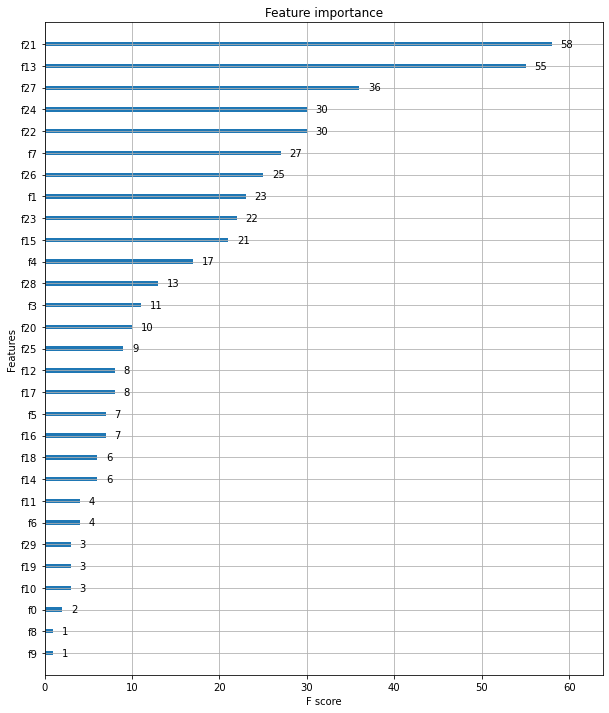

In [42]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))

plot_importance(xgb_wrapper, ax=ax)